In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("/content/drive/MyDrive/named entity recognition/ner_dataset.csv",encoding="latin1")

In [4]:
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [5]:
data = data.fillna(method="ffill")
data.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [6]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [7]:
print("Unique words in corpus :",data["Word"].nunique())
print("Unique tags in corpus :",data["Tag"].nunique())

Unique words in corpus : 35178
Unique tags in corpus : 17


In [8]:
words = list(set(data["Word"].values)) #by converting to sets the duplicates are removed and order is not preserved

In [9]:
words.append("Endpad")

In [10]:
num_of_words = len(words)
num_of_words

35179

In [11]:
tags = list(set(data["Tag"].values))

In [12]:
num_of_tags = len(tags)
num_of_tags

17

In [13]:
class sentecegetter(object):
  def __init__(self,data):
    self.data = data
    agg_fun = lambda s : [(w,p,t) for w,p,t in zip(s["Word"].tolist(),s["POS"].tolist(),s["Tag"].tolist())]
    self.groped = self.data.groupby("Sentence #").apply(agg_fun)
    self.senteces = [s for s in self.groped]

In [14]:
getter = sentecegetter(data)
senteces = getter.senteces

In [ ]:
senteces[0]

In [16]:
word2idx = {w:i+1 for i,w in enumerate(words)}
tag2idx = {t:i for i,t in enumerate(tags)}

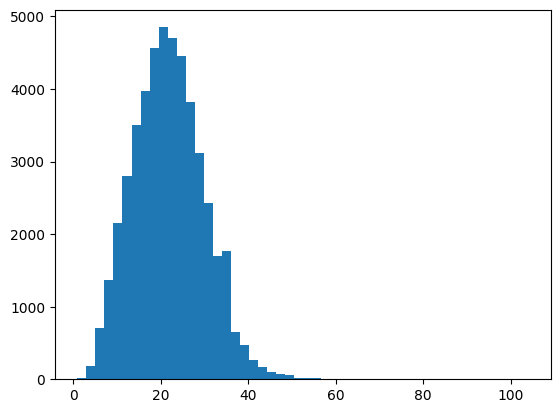

In [17]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in senteces],bins=50)
plt.show()

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
max_len = 50

In [19]:
x = [[word2idx[w[0]] for w in s] for s in senteces]
x = pad_sequences(maxlen=max_len,sequences=x,value=max_len-1,padding="post")
y = [[tag2idx[w[2]] for w in s] for s in senteces]
y = pad_sequences(maxlen = max_len,sequences=y,value=tag2idx["O"],padding="post")
y = [to_categorical(i,num_classes=num_of_tags) for i in y]

In [20]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=1)

In [21]:
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed,SpatialDropout1D,Bidirectional

In [22]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_of_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_of_tags,activation="softmax"))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [23]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

In [24]:
!pip install livelossplot

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [26]:
import numpy as np

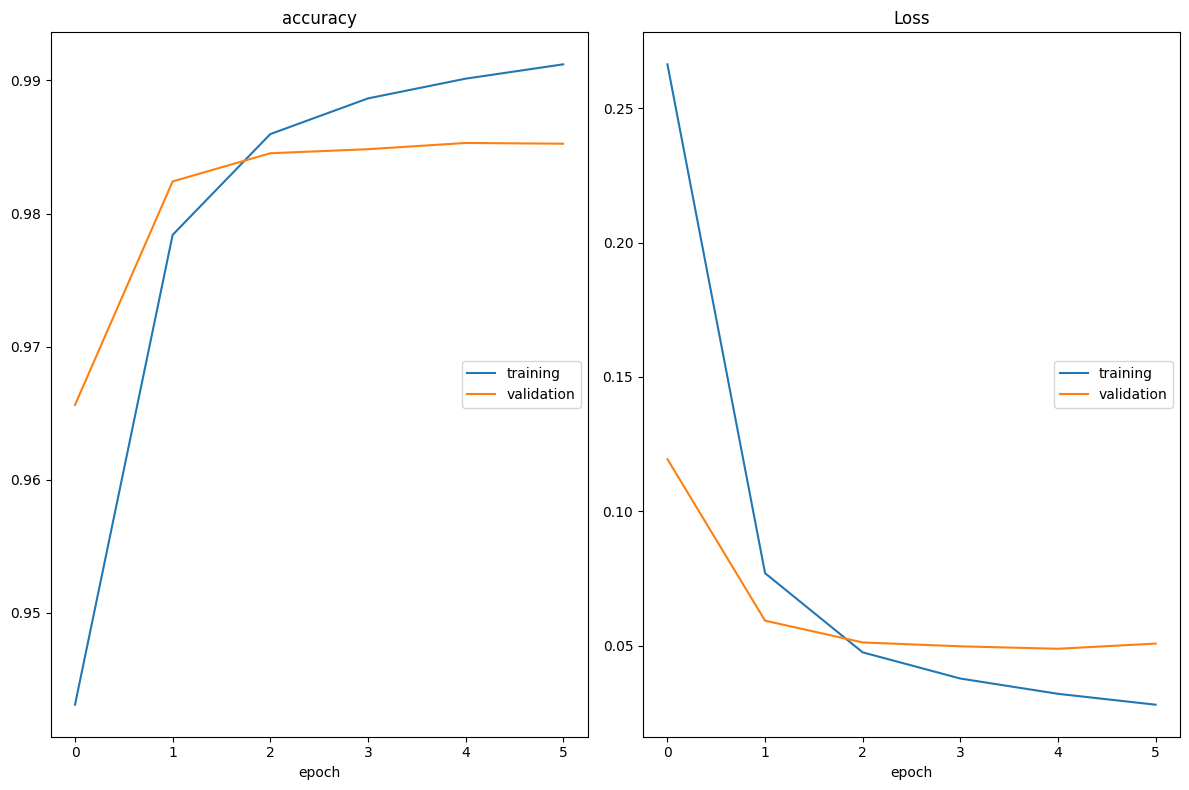

accuracy
	training         	 (min:    0.943, max:    0.991, cur:    0.991)
	validation       	 (min:    0.966, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.028, max:    0.266, cur:    0.028)
	validation       	 (min:    0.049, max:    0.119, cur:    0.051)
540/540 [==============================] - 211s 391ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.0508 - val_accuracy: 0.9852


In [27]:
early_stopping = EarlyStopping(monitor="val_accuracy",patience=1,verbose=0,mode="max",restore_best_weights=True)
callbacks = [PlotLossesCallback(),early_stopping]
model.fit(x_train,np.array(y_train),validation_split=0.2,batch_size=64,epochs=10,verbose=1,callbacks=callbacks)

In [35]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p,axis=-1)

1/1 [==============================] - 0s 42ms/step


In [36]:
y_true = np.argmax(np.array(y_test),axis=-1)[i]

In [38]:
for w , y_tr , pred in zip(x_test[i],y_true,p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[y_tr],tags[pred]))

Israel         B-geo	B-geo
has            O    	O
boycotted      O    	O
the            O    	O
Hamas-led      O    	O
government     O    	O
and            O    	O
ruled          O    	O
out            O    	O
peace          O    	O
talks          O    	O
unless         O    	O
the            O    	O
militant       O    	O
group          O    	O
renounces      O    	O
violence       O    	O
,              O    	O
recognizes     O    	O
Israel         B-geo	B-geo
's             O    	O
right          O    	O
to             O    	O
exist          O    	O
and            O    	O
accepts        O    	O
interim        O    	O
Israeli-       O    	O
Palestinian    B-gpe	B-gpe
accords        O    	O
.              O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O
Finland        O    	O